In [1]:
%load_ext autoreload
%autoreload 2

In [77]:
import yt
import yt.units as u
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from data_binning import *
plt.rcParams.update({
    "text.usetex": True})

In [3]:
G = u.gravitational_constant
q0 = 1e6
beta = 1
M = q0 * u.Msun
rT = q0**(1 / 3) * u.Rsun
deltaE = (G * M / rT**2 * u.Rsun).in_cgs()

In [283]:
class TDE:
    G = u.gravitational_constant
    q0 = 1e6
    beta = 1
    M = q0 * u.Msun
    rT = q0**(1 / 3) * u.Rsun
    deltaE = (G * M / rT**2 * u.Rsun).in_cgs()
    age0 = '0.445'
    ms0 = '1.0'

    def __init__(self,
                 q=q0,
                 Ecc=1,
                 beta=1,
                 file='1.000.dat',
                 ms=ms0,
                 age=age0,
                 DIR=None):
        if DIR == None:
            DIR = '../../STARS_library/retrieval/m{}_t{}/'.format(ms, age)
        with open(DIR + file) as f:
            lines = (line for line in f if not line.startswith('"'))
            dmdt_t0 = np.loadtxt(lines, skiprows=1)
        t0 = dmdt_t0[:, 0]
        dmdt0 = dmdt_t0[:, 1]
        dedt0 = (2 / 3 * (G**2 * M**2 * np.pi**2 / 2)**(1 / 3) *
                 (t0 * u.day)**(-5 / 3)).in_cgs()
        dmde0 = (dmdt0 * (u.Msun / u.yr) / dedt0).in_cgs()
        E = -((G**2 * M**2 * np.pi**2 / 2)**(1 / 3) *
              (t0 * u.day)**(-2 / 3)).in_cgs()
        E_dE = E / deltaE
        dmde_dE = dmde0 * deltaE
        self.M = q * u.Msun
        self.Ecc = Ecc
        self.beta = beta
        self.rT = q**(1 / 3) * u.Rsun
        self.deltaE = (G * self.M / self.rT**2 * u.Rsun).in_cgs()

        self.E = self.E_Ecc(E_dE * self.deltaE)
        self.E_most_bound = self.E_Ecc(-self.deltaE * self.beta**2)
        self.T = ((-self.E**3 * 2)**(-1 / 2) * np.pi * G *
                  self.M).in_units('day')
        self.Tfallback = self.T[0]

        self.dmde = dmde_dE / self.deltaE
        dedt = 2 / 3 * ((G**2 * self.M**2 * np.pi**2 / 2)**(1 / 3) *
                        self.T**(-5 / 3)).in_cgs()
        self.dmdt = (dedt * self.dmde).in_units('Msun/yr')

        #while np.argmax(self.dmdt) + 1 == len(self.dmdt):
        while self.dmdt[-1] > self.dmdt[-2]:
            self.dmdt = self.dmdt[:-1]
            self.T = self.T[:-1]
        self.Tpeak = self.T[np.argmax(self.dmdt)].in_units('day')
        self.Tpeak0 = self.Tpeak - self.Tfallback

        self.Tscale = (self.T - self.Tpeak) / (self.Tpeak - self.T[0])
        self.dmdtscale = self.dmdt / self.dmdt.max()
        self.Tscale *= 1 - self.dmdtscale[0]

        if self.Eorb == 0:
            self.Period = np.inf
        else:
            self.Period = 2 * np.pi * G * self.M / (-2 * self.Eorb)**(3 / 2)
            self.Period = self.Period.in_units('day')

    def E_Ecc(self, E):
        if self.Ecc == 1:
            self.Eorb = 0
        else:
            a = self.rT / self.beta / (1 - self.Ecc)
            self.Eorb = -G * self.M / 2 / a
        return E + self.Eorb

## Tpeak v.s. other parameters

In [5]:
e_cri_1 = 0.9825
e_cri_5 = .93166

In [6]:
def P2Ecc(P, M=1 * u.Msun, R=1 * u.Rsun, beta=1):
    return 1 - (4 * np.pi**2 / P**2 / G / M)**(1 / 3) * R / beta

Text(0.5, 0, '$q$')

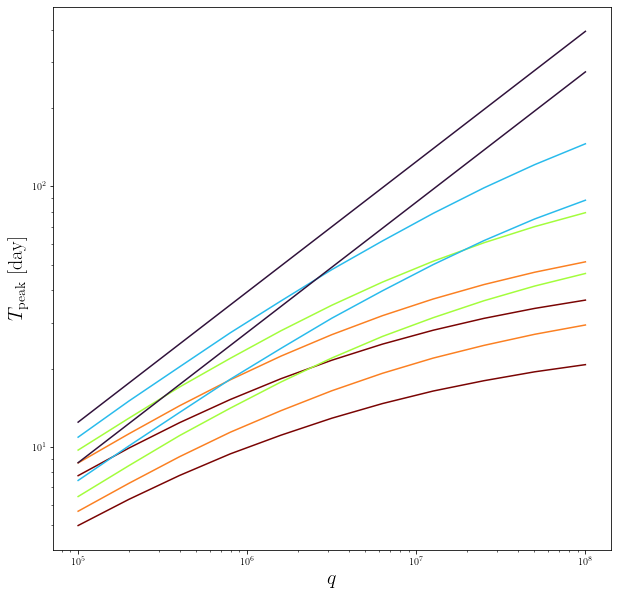

In [7]:
plt.figure(figsize=(10, 10))
q_range = np.logspace(5, 8, 11)

cmap = cm.get_cmap('turbo', 5)

files = ['1.000.dat', '1.500.dat', '2.000.dat']

for f in files[:2]:
    for level, ecc in enumerate(np.linspace(1, e_cri_1, 5)):
        #tde0 = [TDE(q=q, file=f, beta=float(f[:3])) for q in q_range]
        #plt.loglog(q_range, [tde.Tpeak for tde in tde0])
        tde_temp = [TDE(q=q, Ecc=ecc, file=f, beta=float(f[:3])) for q in q_range]
        plt.loglog(q_range, [tde.Tpeak for tde in tde_temp], color=cmap(level))
        Tpeak_ratio_analyt_temp = (((1 - ecc) / 2 + q_range**(-1 / 3)) /
                                   ((1 - ecc) / 2 + q_range[0]**(-1 / 3)))**(-3 /
                                                                             2)
        '''plt.loglog(q_range,
                   tde_temp[0].Tpeak * Tpeak_ratio_analyt_temp,
                   color=cmap(level),
                   linestyle=':')'''
        
plt.ylabel('$T_\mathrm{peak}\ \mathrm{[day]}$', fontsize=20)
plt.xlabel('$q$', fontsize=20)

Text(0.5, 0, '$q$')

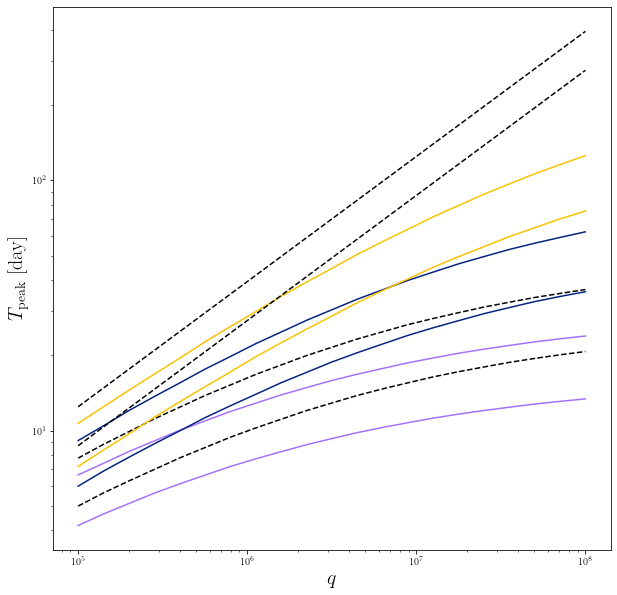

In [8]:
plt.figure(figsize=(10, 10))
q_range = np.logspace(5, 8, 21)

Ecc = P2Ecc(P=np.array([30, 100, 300])*u.day)

cmap = cm.get_cmap('Haze', 3)

for f in files[:2]:
    tde0 = [TDE(q=q, file=f, beta=float(f[:3])) for q in q_range]
    plt.loglog(q_range, [tde.Tpeak for tde in tde0], color='k', linestyle='--')
    tde_cri = [TDE(q=q, Ecc=e_cri_1, file=f, beta=float(f[:3])) for q in q_range]
    plt.loglog(q_range, [tde.Tpeak for tde in tde_cri], color='k', linestyle='--')
    for level, ecc in enumerate(Ecc):
        tde_temp = [TDE(q=q, Ecc=ecc, file=f, beta=float(f[:3])) for q in q_range]
        plt.loglog(q_range, [tde.Tpeak for tde in tde_temp], color=cmap(level))
        Tpeak_ratio_analyt_temp = (((1 - ecc) / 2 + q_range**(-1 / 3)) /
                                   ((1 - ecc) / 2 + q_range[0]**(-1 / 3)))**(-3 /
                                                                             2)
        '''plt.loglog(q_range,
                   tde_temp[0].Tpeak * Tpeak_ratio_analyt_temp,
                   color=cmap(level),
                   linestyle=':')'''
plt.ylabel('$T_\mathrm{peak}\ \mathrm{[day]}$', fontsize=20)
plt.xlabel('$q$', fontsize=20)

In [9]:
from astropy.table import Table

16


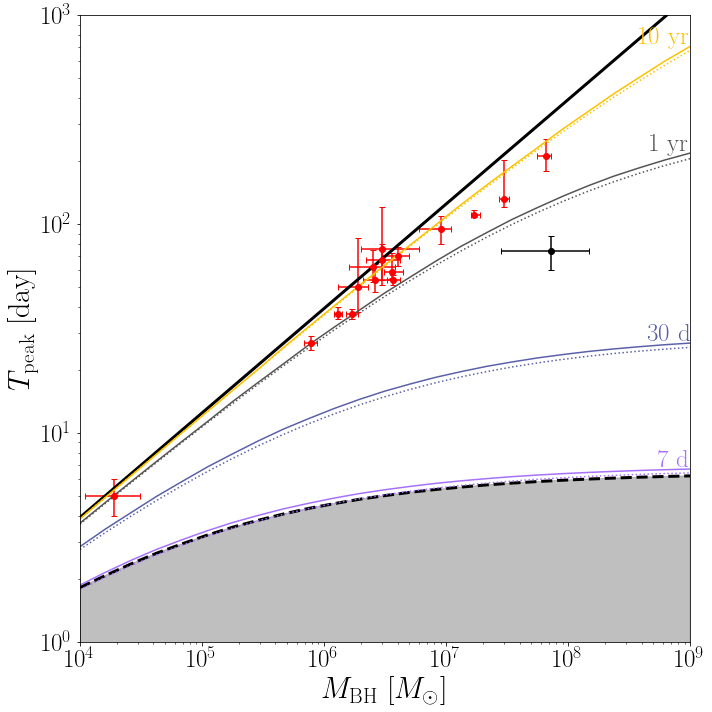

In [10]:
#ASASSN14ko
ASMh = 10**7.86
ASMheup = 10**(7.86 + 0.31) - ASMh
ASMhelo = ASMh - 10**(7.86 - 0.41)

ASMh_fit = 10**7.81
ASMheup_fit = 10**(7.81 + 0.17) - ASMh
ASMhelo_fit = ASMh - 10**(7.81 - 0.29)

AStp = 74
AStpeup = 14
AStpelo = 14

AStp2 = 44
AStpeup2 = 3
AStpelo2 = 3

M_tpeak = Table.read('M_tpeak.csv', comment='#')
print(len(M_tpeak))
Mherr = np.array([-M_tpeak['Mhe-'], M_tpeak['Mhe+']]) * 1e6
tperr = np.array([-M_tpeak['tpe-'], M_tpeak['tpe+']])

plt.figure(figsize=(10, 10))

plt.errorbar(M_tpeak['Mh'] * 1e6,
             M_tpeak['tp'],
             xerr=Mherr,
             yerr=tperr,
             fmt='o',
             capsize=3,
             color='r')

plt.errorbar(ASMh,
             AStp,
             xerr=[[ASMhelo], [ASMheup]],
             yerr=[[AStpelo], [AStpeup]],
             fmt='o',
             capsize=3,
             color='k')

q_range = np.logspace(4, 9, 25)
tde0 = [TDE(q=q, file='1.000.dat') for q in q_range]
plt.loglog(q_range, [tde.Tpeak for tde in tde0], color='k', linewidth=3)
tde_cri = [TDE(q=q, Ecc=e_cri_5, file='1.000.dat') for q in q_range]
plt.loglog(q_range, [tde.Tpeak for tde in tde_cri],
           color='k',
           linestyle='--',
           linewidth=3)
plt.fill_between(q_range, [tde.Tpeak for tde in tde_cri],
                 color='grey',
                 alpha=0.5)

P_range = np.array([7, 30, 365.25, 3652.5]) * u.day
Ecc = P2Ecc(P_range)

cmap = cm.get_cmap('Haze', 4)

S = [None, None, '$1\ \mathrm{yr}$', '$10\ \mathrm{yr}$']

for level, ecc in enumerate(Ecc):
    tde_temp = [TDE(q=q, Ecc=ecc, file='1.000.dat') for q in q_range]
    plt.loglog(q_range, [tde.Tpeak for tde in tde_temp], color=cmap(level))
    if S[level] == None:
        s = '${:.0f}$'.format(P_range[level].v) + '$\ \mathrm{d}$'
    else:
        s = S[level]
    plt.text(x=q_range[-1],
             y=tde_temp[-1].Tpeak * 1.03,
             s=s,
             fontsize=25,
             ha='right',
             color=cmap(level))
    Tpeak_ratio_analyt_temp = ((1 - ecc) * q_range**(1 / 3) / 2 + 1)**(-3 / 2)
    plt.loglog(q_range, [tde.Tpeak for tde in tde0] * Tpeak_ratio_analyt_temp,
               color=cmap(level),
               linestyle=':')
plt.xlim(1e4, 1e9)
plt.ylim(1e0, 1e3)
plt.ylabel('$T_\mathrm{peak}\ \mathrm{[day]}$', fontsize=30)
plt.xlabel('$M_\mathrm{BH}\ [M_\odot]$', fontsize=30)
plt.gca().tick_params(labelsize=25)
plt.tight_layout()
#plt.savefig('Tp_q.pdf', bbox_inches='tight')

## Mdot v.s. t

In [11]:
#P = 114 day, beta = 1, Ecc?
Ecc114 = 1 - ((2 * np.pi / 114 / u.day)**2 / G / u.Msun)**(1 / 3) * u.Rsun
Ecc114

unyt_quantity(0.98989573, '(dimensionless)')

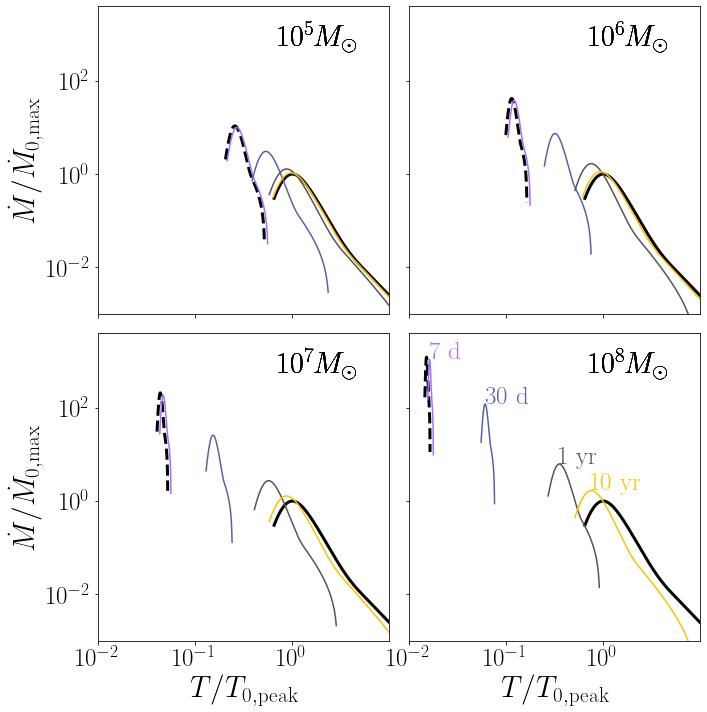

In [12]:
f, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = ax.flatten()
Q = [1e5, 1e6, 1e7, 1e8]

k = 0
for a, q in zip(ax, Q):
    tde0 = TDE(Ecc=1, beta=1.0, file='1.000.dat', q=q)
    Tpeak0 = tde0.Tpeak
    dmdt0 = tde0.dmdt.max()
    a.loglog(tde0.T / Tpeak0, tde0.dmdt / dmdt0, color='k', linewidth=3)

    tde_cri = TDE(Ecc=e_cri_5, beta=1.0, file='1.000.dat', q=q)
    a.loglog(tde_cri.T / Tpeak0,
             tde_cri.dmdt / dmdt0,
             color='k',
             linestyle='--',
             linewidth=3)

    P_range = np.array([7, 30, 365.25, 3652.5]) * u.day
    Ecc = P2Ecc(P_range)
    cmap = cm.get_cmap('Haze', 4)

    for level, ecc in enumerate(Ecc):
        tde = TDE(Ecc=ecc, beta=1.0, file='1.000.dat', q=q)
        a.loglog(tde.T / Tpeak0, tde.dmdt / dmdt0, color=cmap(level))
        if S[level] == None:
            s = '${:.0f}$'.format(P_range[level].v) + '$\ \mathrm{d}$'
        else:
            s = S[level]
        a.text(x=0.9,
               y=0.9,
               s=r'$10^{:.0f}M_\odot$'.format(np.log10(q)),
               fontsize=30,
               ha='right',
               va='center',
               transform=a.transAxes)
        if k == 3:
            a.text(x=tde.T[np.argmax(tde.dmdt)] / Tpeak0,
                   y=tde.dmdt.max() / dmdt0 * 1.05,
                   s=s,
                   fontsize=25,
                   color=cmap(level))

    a.tick_params(labelsize=25)
    k += 1

ax[0].set_ylabel('$\dot M/\dot M_\mathrm{0, max}$', fontsize=30)
ax[2].set_ylabel('$\dot M/\dot M_\mathrm{0, max}$', fontsize=30)
ax[2].set_xlabel('$T/T_\mathrm{0, peak}$', fontsize=30)
ax[3].set_xlabel('$T/T_\mathrm{0, peak}$', fontsize=30)
plt.tight_layout()
plt.xlim(1e-2, 1e1)
plt.ylim(1e-3, 4e3)
plt.xticks([1e-2, 1e-1, 1e0])
plt.yticks([1e-2, 1e0, 1e2])
plt.savefig('Mdot_T.pdf', bbox_inches='tight')

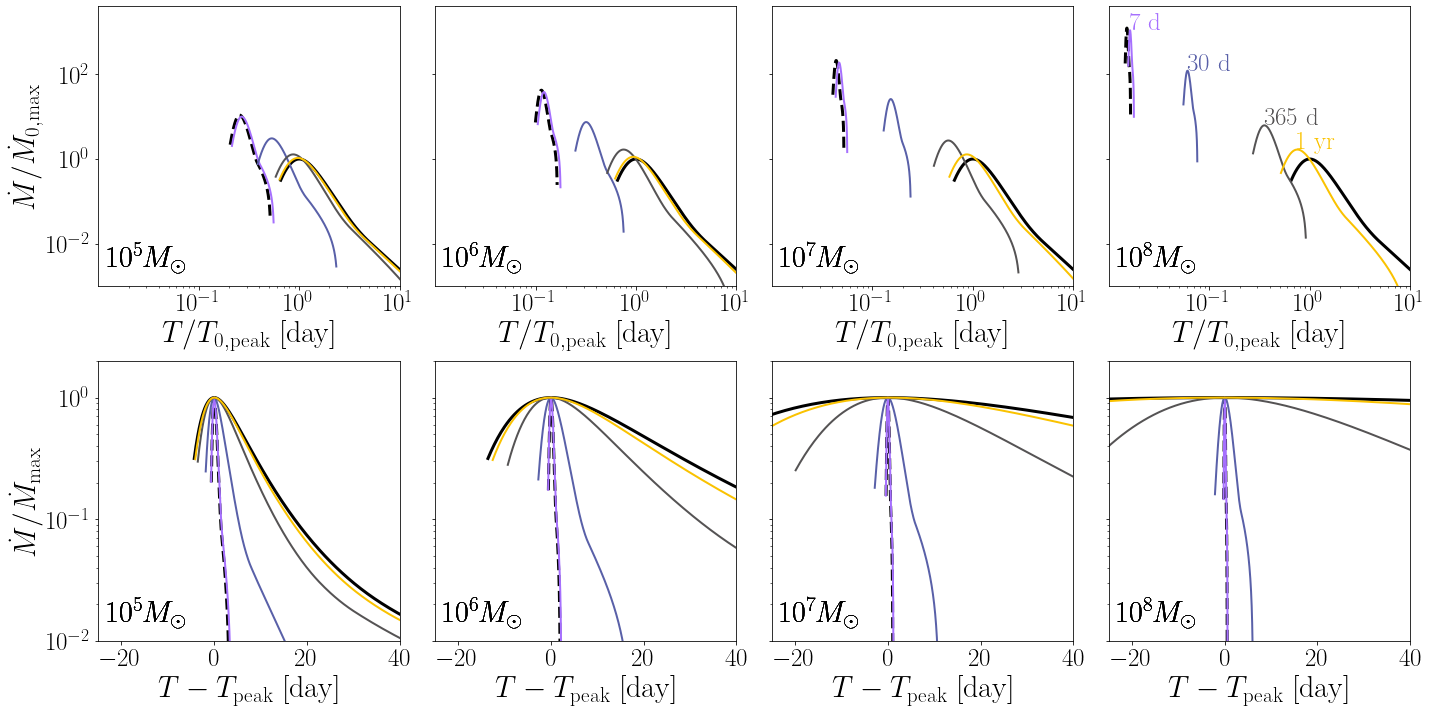

In [192]:
f, ax = plt.subplots(2, 4, figsize=(20, 10), sharex='row', sharey='row')

Q = [1e5, 1e6, 1e7, 1e8]

for a, q in zip(ax[1], Q):
    a.set_yscale('log')

    tde0 = TDE(Ecc=1, beta=1.0, file='1.000.dat', q=q)
    a.plot(tde0.T - tde0.Tpeak,
           tde0.dmdt / tde0.dmdt.max(),
           color='k',
           linewidth=3)

    tde_cri = TDE(Ecc=e_cri_5, beta=1.0, file='1.000.dat', q=q)
    a.plot(tde_cri.T - tde_cri.Tpeak,
           tde_cri.dmdt / tde_cri.dmdt.max(),
           color='k',
           linestyle='--',
           linewidth=3)

    P_range = np.array([7, 30, 365.25, 3652.5]) * u.day
    Ecc = P2Ecc(P_range)
    cmap = cm.get_cmap('Haze', 4)

    for level, ecc in enumerate(Ecc):
        tde = TDE(Ecc=ecc, beta=1.0, file='1.000.dat', q=q)
        a.plot(tde.T - tde.Tpeak,
               tde.dmdt / tde.dmdt.max(),
               color=cmap(level),
               linewidth=2)
        if S[level] == None:
            s = '${:.0f}$'.format(P_range[level].v) + '$\ \mathrm{d}$'
        else:
            s = S[level]
        a.text(x=0.3,
               y=0.1,
               s=r'$10^{:.0f}M_\odot$'.format(np.log10(q)),
               fontsize=30,
               ha='right',
               va='center',
               transform=a.transAxes)

    a.set_xlim(-25, 40)
    a.set_ylim(1e-2, 2e0)
    a.set_xticks([-20, 0, 20, 40])
    a.tick_params(labelsize=25)
    a.set_xlabel('$T-T_\mathrm{peak}\ [\mathrm{day}]$', fontsize=30)

k = 0
for a, q in zip(ax[0], Q):
    tde0 = TDE(Ecc=1, beta=1.0, file='1.000.dat', q=q)
    Tpeak0 = tde0.Tpeak
    dmdt0 = tde0.dmdt.max()
    a.loglog(tde0.T / Tpeak0, tde0.dmdt / dmdt0, color='k', linewidth=3)

    tde_cri = TDE(Ecc=e_cri_5, beta=1.0, file='1.000.dat', q=q)
    a.loglog(tde_cri.T / Tpeak0,
             tde_cri.dmdt / dmdt0,
             color='k',
             linestyle='--',
             linewidth=3)

    P_range = np.array([7, 30, 365.25, 3652.5]) * u.day
    Ecc = P2Ecc(P_range)
    cmap = cm.get_cmap('Haze', 4)

    for level, ecc in enumerate(Ecc):
        tde = TDE(Ecc=ecc, beta=1.0, file='1.000.dat', q=q)
        a.loglog(tde.T / Tpeak0,
                 tde.dmdt / dmdt0,
                 color=cmap(level),
                 linewidth=2)
        if S[level] == None:
            s = '${:.0f}$'.format(P_range[level].v) + '$\ \mathrm{d}$'
        else:
            s = S[level]
        a.text(x=0.3,
               y=0.1,
               s=r'$10^{:.0f}M_\odot$'.format(np.log10(q)),
               fontsize=30,
               ha='right',
               va='center',
               transform=a.transAxes)
        if k == 3:
            a.text(x=tde.T[np.argmax(tde.dmdt)] / Tpeak0,
                   y=tde.dmdt.max() / dmdt0 * 1.05,
                   s=s,
                   fontsize=25,
                   color=cmap(level))

    a.tick_params(labelsize=25)
    a.set_xlabel('$T/T_\mathrm{0, peak}\ [\mathrm{day}]$', fontsize=30)
    a.set_xlim(1e-2, 1e1)
    a.set_ylim(1e-3, 4e3)
    a.set_xticks([1e-1, 1e0, 1e1])
    a.set_yticks([1e-2, 1e0, 1e2])
    k += 1

ax[1, 0].set_ylabel('$\dot M/\dot M_\mathrm{max}$', fontsize=30)
ax[0, 0].set_ylabel('$\dot M/\dot M_\mathrm{0, max}$', fontsize=30)

plt.tight_layout()

#plt.yticks([1e-2, 1e0, 1e2])
plt.savefig('Mdot_T.pdf', bbox_inches='tight')

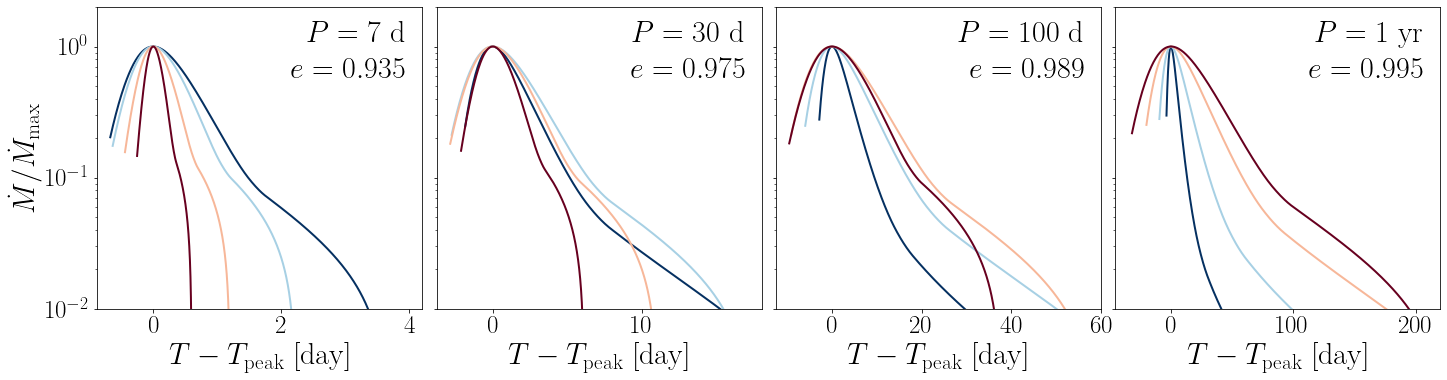

In [207]:
f, ax = plt.subplots(1, 4, figsize=(20, 5.5), sharey=True)
Q = [1e5, 1e6, 1e7, 1e8]

P_range = np.array([7, 30, 100, 365.25]) * u.day
Ecc = P2Ecc(P_range)
cmap = cm.get_cmap('RdBu_r', 4)
S = [None, None, None, '1\ \mathrm{yr}']
for k, (a, ecc) in enumerate(zip(ax, Ecc)):
    for level, q in enumerate(Q):
        tde = TDE(Ecc=ecc, beta=1.0, file='1.000.dat', q=q)
        a.plot(tde.T - tde.Tpeak,
               tde.dmdt / tde.dmdt.max(),
               color=cmap(level),
               linewidth=2)
    if S[k] == None:
        s = '{:.0f}'.format(P_range[k].v) + '\ \mathrm{d}'
    else:
        s = S[k]
    s = '$P={}$'.format(s)
    a.text(x=0.95,
           y=0.91,
           s=s,
           fontsize=30,
           ha='right',
           va='center',
           transform=a.transAxes)
    a.text(x=0.95,
           y=0.79,
           s='$e={:.3f}$'.format(ecc.v),
           fontsize=30,
           ha='right',
           va='center',
           transform=a.transAxes)

    a.tick_params(labelsize=25)
    a.set_xlabel('$T-T_\mathrm{peak}\ [\mathrm{day}]$', fontsize=30)
    a.set_ylim(1e-2, 2e0)

ax[0].set_ylabel('$\dot M/\dot M_\mathrm{max}$', fontsize=30)
ax[0].set_xlim(-0.875, 4.2)
ax[1].set_xlim(-3.75, 18)
ax[2].set_xlim(-12.5, 60)
ax[3].set_xlim(-45.3, 220)
plt.tight_layout()
plt.yscale('log')
#plt.xticks([1e-2, 1e-1, 1e0])
#plt.yticks([1e-2, 1e0, 1e2])
plt.savefig('Duration.pdf', bbox_inches='tight')

In [53]:
TESS = np.loadtxt('../mosfit_bin/TESS_mag.dat')
TESS = TESS[TESS[:, 0] > 2458429]
TESS = TESS[TESS[:, 1] > 0]

TESS = data_binning(TESS, 1)

tpeak = TESS[np.argmin(TESS[:, 1]), 0]
TESS_tscale = (TESS[:, 0] - tpeak)# / (tpeak - TESS[0, 0])# / 1.2
TESS_dmdtscale = 10**(-0.4 * (TESS[:, 1] - TESS[:, 1].min()))
TESS_dmdterrscale = TESS_dmdtscale * (1 - 10**(-0.4 * TESS[:, 2]))

ASg = np.loadtxt('../mosfit_bin/ASg_mag.dat')
ASg = ASg[ASg[:, 0] > 2458429]
ASg = ASg[ASg[:, 1] > 0]

tpeak = ASg[np.argmin(ASg[:, 1]), 0]#ASg[3, 0]
ASg_tscale = (ASg[:, 0] - tpeak)# / (tpeak - ASg[0, 0]) / 2
ASg_dmdtscale = 10**(-0.4 * (ASg[:, 1] - ASg[:, 1].min()))
ASg_dmdterrscale = ASg_dmdtscale * (1 - 10**(-0.4 * ASg[:, 2]))

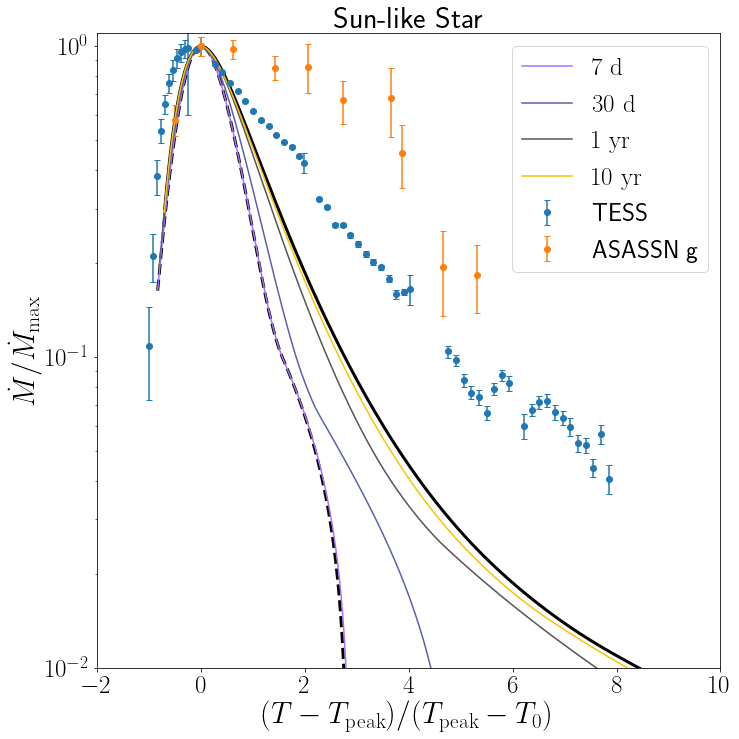

In [42]:
plt.figure(figsize=(10, 10))

tde0 = TDE(Ecc=1, beta=1.0, file='1.000.dat')
Tpeak0 = tde0.Tpeak
dmdt0 = tde0.dmdt.max()
plt.plot(tde0.Tscale, tde0.dmdtscale, color='k', linewidth=3)

tde_cri = TDE(Ecc=e_cri_5, beta=1.0, file='1.000.dat')
plt.plot(tde_cri.Tscale,
         tde_cri.dmdtscale,
         color='k',
         linestyle='--',
         linewidth=3)

P_range = np.array([7, 30, 365.25, 3652.5]) * u.day
Ecc = P2Ecc(P_range)
cmap = cm.get_cmap('Haze', 4)

plt.errorbar(TESS_tscale,
             TESS_dmdtscale,
             yerr=TESS_dmdterrscale,
             fmt='o',
             capsize=3,
             label='TESS')

plt.errorbar(ASg_tscale,
             ASg_dmdtscale,
             yerr=ASg_dmdterrscale,
             fmt='o',
             capsize=3,
             label='ASASSN g')

for level, ecc in enumerate(Ecc):
    tde = TDE(Ecc=ecc, beta=1.0, file='1.000.dat')
    if S[level] == None:
        s = '${:.0f}$'.format(P_range[level].v) + '$\ \mathrm{d}$'
    else:
        s = S[level]
    plt.plot(tde.Tscale, tde.dmdtscale, color=cmap(level), label=s)
    '''plt.text(x=tde.T[np.argmax(tde.dmdt)] / Tpeak0,
             y=tde.dmdt.max() / dmdt0 * 1.05,
             s=s,
             fontsize=25,
             color=cmap(level))'''

plt.ylabel('$\dot M/\dot M_\mathrm{max}$', fontsize=30)
plt.xlabel('$(T-T_\mathrm{peak})/(T_\mathrm{peak}-T_0)$', fontsize=30)
plt.gca().tick_params(labelsize=25)
plt.tight_layout()
plt.xlim(-2, 10)
plt.ylim(1e-2, 1.1e0)
plt.legend(prop={'size': 25})
#plt.xscale('log')
plt.yscale('log')
plt.title('Sun-like Star', fontsize=30)
plt.savefig('/Users/chang/Desktop/Mdot_T_sun.pdf', bbox_inches='tight')

<ErrorbarContainer object of 3 artists>

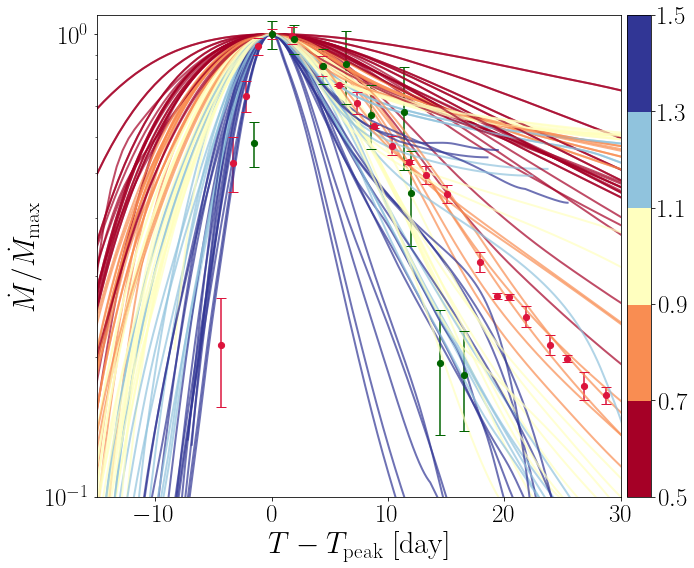

In [387]:
plt.figure(figsize=(10, 8))

ecc = P2Ecc(114.2 * u.day)
Age = ['0.0', '0.445', '1.0']
Input = '../../STARS_library/input/'

cmap = cm.get_cmap('RdYlBu', 5)
betac = 1.5
beta0 = 0.5
Beta = []
betamax = 0
for Dir in os.listdir(Input):
    for f in os.listdir(Input + Dir):
        beta = float(f[:-4])
        if beta <= betac:
            if beta > betamin:
                betamax = beta
            Beta.append(beta)
            tde = TDE(Ecc=ecc,
                      beta=beta,
                      file=f,
                      DIR=Input + Dir + '/',
                      q=10**7.86,
                      age=age)
            plt.plot(tde.T - tde.Tpeak,
                     tde.dmdtscale,
                     color=cmap((beta - beta0) / (betac - beta0)),
                     alpha=0.7,
                     linewidth=2)
    '''plt.text(x=tde.T[np.argmax(tde.dmdt)] / Tpeak0,
             y=tde.dmdt.max() / dmdt0 * 1.05,
             s=s,
             fontsize=25,
             color=cmap(level))'''

sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=beta0, vmax=betac))
cbar = plt.colorbar(sm, pad=0.01)
cbar.ax.tick_params(labelsize=25)
cbar.set_ticks(np.linspace(0.5, 1.5, 6))

plt.ylabel('$\dot M/\dot M_\mathrm{max}$', fontsize=30)
plt.xlabel('$T-T_\mathrm{peak}\ [\mathrm{day}]$', fontsize=30)
plt.gca().tick_params(labelsize=25)
plt.tight_layout()
plt.xlim(-15, 30)
plt.ylim(1e-1, 1.1e0)
#plt.legend(prop={'size': 25})
#plt.xscale('log')
plt.yscale('log')

plt.errorbar(TESS_tscale,
             TESS_dmdtscale,
             yerr=TESS_dmdterrscale,
             fmt='o',
             capsize=5,
             ms=6.18,
             color='crimson',
             label='$\mathrm{TESS}$')

plt.errorbar(ASg_tscale,
             ASg_dmdtscale,
             yerr=ASg_dmdterrscale,
             fmt='o',
             capsize=5,
             ms=6.18,
             color='darkgreen',
             label='$\mathrm{ASASSN}\ g$')
#plt.savefig('/Users/chang/Desktop/Mdot_T_sun.pdf', bbox_inches='tight')

In [211]:
10**7.86, 10**(7.86-0.41), 10**(7.86+0.31)

(72443596.00749905, 28183829.31264455, 147910838.8168207)

In [310]:
def rhoc_rho(title):
    if Dir[4] == '_':
        Ms = float(Dir[1:4])
        age = float(Dir[6:])
    else:
        Ms = float(Dir[1:5])
        age = float(Dir[7:])
    if Ms == 0.1:
        return 5.5
    if Ms == 0.3:
        return 5.8
    if Ms == 0.5:
        if age == 0:
            return 11
        else:
            return 12
    if Ms == 0.7:
        if age == 0:
            return 23
        else:
            return 36
    if Ms == 1.0:
        if age == 0:
            return 42
        elif age == 1:
            return 756
        else:
            return 138
    if Ms == 1.5:
        if age == 0:
            return 128
        else:
            return 1697
    if Ms == 3.0:
        if age == 0:
            return 73
        else:
            return 1198
    if Ms == 10:
        if age == 0:
            return 38
        else:
            return 1292

<ipython-input-366-f212ee8bb28e>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(


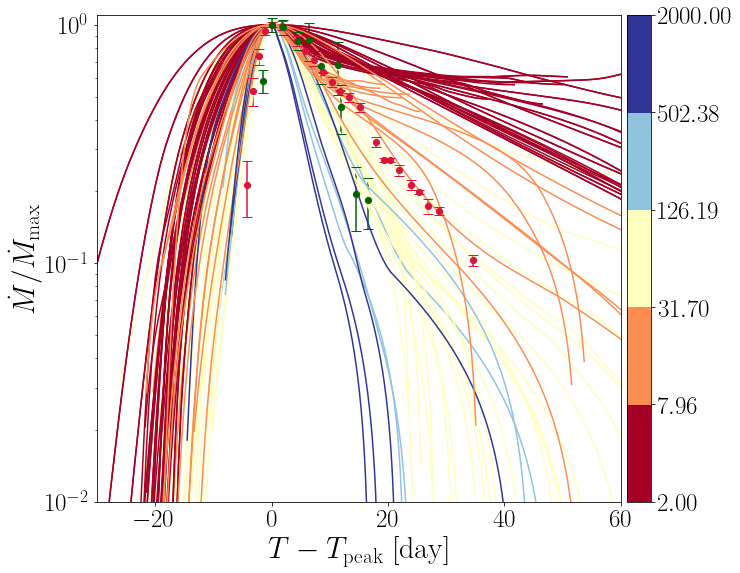

In [366]:
plt.figure(figsize=(10, 8))

ecc = P2Ecc(114.2 * u.day)
Age = ['0.0', '0.445', '1.0']
Input = '../../STARS_library/input/'

cmap = cm.get_cmap('RdYlBu', 5)
logMc = 1
logM0 = -1
for Dir in os.listdir(Input):
    if Dir[4] == '_':
        Ms = float(Dir[1:4])
    else:
        Ms = float(Dir[1:5])
    for f in os.listdir(Input + Dir):
        beta = float(f[:-4])
        if beta <= betac:
            tde = TDE(Ecc=ecc,
                      beta=beta,
                      file=f,
                      DIR=Input + Dir + '/',
                      q=10**7.86,
                      age=age)
            plt.plot(tde.T - tde.Tpeak,
                     tde.dmdtscale,
                     color=cmap(np.log10(rhoc_rho(Dir)/2) / np.log10(1000)))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
cbar = plt.colorbar(sm, pad=0.01)

plt.ylabel('$\dot M/\dot M_\mathrm{max}$', fontsize=30)
plt.xlabel('$T-T_\mathrm{peak}\ [\mathrm{day}]$', fontsize=30)
plt.gca().tick_params(labelsize=25)
plt.tight_layout()
plt.xlim(-30, 60)
plt.ylim(1e-2, 1.1e0)
#plt.legend(prop={'size': 25})
#plt.xscale('log')
plt.yscale('log')

plt.errorbar(TESS_tscale,
             TESS_dmdtscale,
             yerr=TESS_dmdterrscale,
             fmt='o',
             capsize=5,
             ms=6.18,
             color='crimson',
             label='$\mathrm{TESS}$')

plt.errorbar(ASg_tscale,
             ASg_dmdtscale,
             yerr=ASg_dmdterrscale,
             fmt='o',
             capsize=5,
             ms=6.18,
             color='darkgreen',
             label='$\mathrm{ASASSN}\ g$')

cbar.ax.set_yticklabels(
    ['${:.2f}$'.format(i) for i in 2*1000**(np.arange(6) / 5)], fontsize=25)
#plt.savefig('/Users/chang/Desktop/Mdot_T_sun.pdf', bbox_inches='tight')
plt.show()

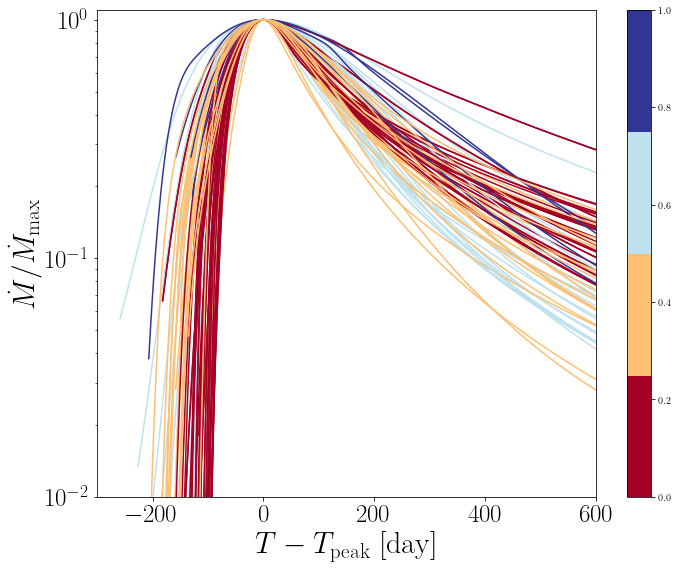

In [358]:
plt.figure(figsize=(10, 8))

ecc = P2Ecc(114.2 * u.day)
Age = ['0.0', '0.445', '1.0']
Input = '../../STARS_library/input/'

cmap = cm.get_cmap('RdYlBu', 4)
logMc = 1
logM0 = -1
for Dir in os.listdir(Input):
    if Dir[4] == '_':
        Ms = float(Dir[1:4])
    else:
        Ms = float(Dir[1:5])
    for f in os.listdir(Input + Dir):
        beta = float(f[:-4])
        if beta <= betac:
            tde = TDE(Ecc=1,
                      beta=beta,
                      file=f,
                      DIR=Input + Dir + '/',
                      q=10**7.86,
                      age=age)
            plt.plot(tde.T - tde.Tpeak,
                       tde.dmdtscale,
                       color=cmap(np.log10(rhoc_rho(Dir)) / np.log10(1700)))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
plt.colorbar(sm)

plt.ylabel('$\dot M/\dot M_\mathrm{max}$', fontsize=30)
plt.xlabel('$T-T_\mathrm{peak}\ [\mathrm{day}]$', fontsize=30)
plt.gca().tick_params(labelsize=25)
plt.tight_layout()
plt.xlim(-300, 600)
plt.ylim(1e-2, 1.1e0)
#plt.legend(prop={'size': 25})
#plt.xscale('log')
plt.yscale('log')
#plt.savefig('/Users/chang/Desktop/Mdot_T_sun.pdf', bbox_inches='tight')